# Experiments on Differentiable Bayesian Structure Learning



In [1]:
# for google colab
%pip install --quiet dibs-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [2]:
import jax
print(f"JAX backend: {jax.default_backend()}")

JAX backend: gpu


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dibs.inference import JointDiBS, MarginalDiBS
from dibs.target import make_linear_gaussian_equivalent_model
from dibs.utils import visualize_ground_truth, visualize
import jax.random as random
from dibs.models.graph import ErdosReniDAGDistribution, ScaleFreeDAGDistribution
from dibs.models import LinearGaussian, BGe, DenseNonlinearGaussian
from dibs.target import make_synthetic_bayes_net

## E1: Influence of choice of edge probability in ER-prior on DIBS performance

In [4]:
MAIN_KEY = random.PRNGKey(0)
N_VARS = 20
N_PARTICLES = N_VARS
SVGD_STEPS = 3000
OUTPUT_DIR = "output"
N_NETWORKS = 10
N_OBSERVATIONS = 100

In [5]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_marginal_likelihood

# Helper function to calculate scores
def calculate_scores(dibs_empirical, ground_truth, eltwise_log_marginal_likelihood_observ, x):

    eshd = expected_shd(dist=dibs_empirical, g=ground_truth)
    auroc = threshold_metrics(dist=dibs_empirical, g=ground_truth)['roc_auc']
    negll = neg_ave_log_marginal_likelihood(
        dist=dibs_empirical, eltwise_log_marginal_likelihood=eltwise_log_marginal_likelihood_observ, x=x
    )
    return eshd, auroc, negll

def calculate_edges_per_node(p_edge, n_vars):
    return p_edge * (n_vars - 1) / 2

def calculate_p_edge(n_edges, n_vars):
        p_edge = n_edges / ((n_vars * (n_vars - 1)) / 2)

In [6]:
def simulate_data(
      key,
      n_vars=20,
      graph_prior_str='sf',
      bge_mean_obs=None,
      bge_alpha_mu=None,
      bge_alpha_lambd=None,
      obs_noise=0.1,
      mean_edge=0.0,
      sig_edge=1.0,
      min_edge=0.5,
      n_observations=100,
      n_ho_observations=100,
      edge_p=0.5
    ):
    assert graph_prior_str in ['er', 'sf']

    print("KEY", key)

    # DiBS uses the edges_per_node instead of p
    edges_per_node = calculate_edges_per_node(edge_p, n_vars)

    # Graph Model
    if graph_prior_str == 'sf':
        graph_model = ScaleFreeDAGDistribution(
            n_vars=n_vars,
            n_edges_per_node=edges_per_node
        )
    elif graph_prior_str == 'er':
        graph_model = ErdosReniDAGDistribution(
            n_vars=n_vars,
            n_edges_per_node=edges_per_node
        )
    else:
        graph_model = None

    # Generative Model
    generative_model = LinearGaussian(
      n_vars=n_vars,
      obs_noise=obs_noise,
      mean_edge=mean_edge,
      sig_edge=sig_edge,
      min_edge=min_edge,
    )

    # Likelihood Model
    likelihood_model = BGe(
      n_vars=n_vars,
      mean_obs=bge_mean_obs,
      alpha_mu=bge_alpha_mu,
      alpha_lambd=bge_alpha_lambd,
    )

    # Sample synthetic BN and observations
    key, subk = random.split(key)

    data = make_synthetic_bayes_net(
        key=subk,
        n_vars=n_vars,
        graph_model=graph_model,
        generative_model=generative_model,
        n_observations=n_observations,
        n_ho_observations=n_ho_observations,
    )

    visualize_ground_truth(data.g)

    return data, graph_model, likelihood_model


def run_experiment(key, data, graph_model, likelihood_model, n_particles, svgd_steps, output_dir):
    dibs = MarginalDiBS(
        x=data.x, interv_mask=None, graph_model=graph_model, likelihood_model=likelihood_model
    )
    key, subk = random.split(key)
    gs = dibs.sample(key=subk, n_particles=n_particles, steps=svgd_steps)

    #visualize(gs, svgd_steps, save_path=output_dir, show=False)
    dibs_empirical = dibs.get_empirical(gs)

    eshd, auroc, negll = calculate_scores(
        dibs_empirical, data.g, dibs.eltwise_log_marginal_likelihood_observ, data.x
    )

    return eshd, auroc, negll

In [7]:
MEAN_EDGES_PER_NODE_LOWER = round(calculate_edges_per_node(0.2, N_VARS))
MEAN_EDGES_PER_NODE_UPPER = round(calculate_edges_per_node(0.8, N_VARS))


In [8]:
print(f"edges_per_node_LOWER {MEAN_EDGES_PER_NODE_LOWER}")
print(f"edges_per_node_UPPER {MEAN_EDGES_PER_NODE_UPPER}")

edges_per_node_LOWER 2
edges_per_node_UPPER 8


Running experiments for network 1/10
Key:  [3668660785  713825972]
KEY [3668660785  713825972]


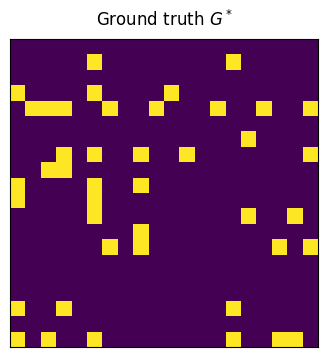

KEY [3668660785  713825972]


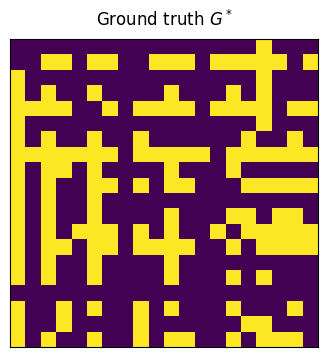

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 2/10
Key:  [1185646547 2092858387]
KEY [1185646547 2092858387]


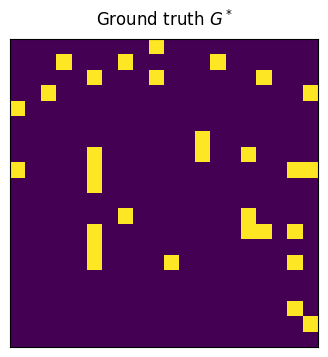

KEY [1185646547 2092858387]


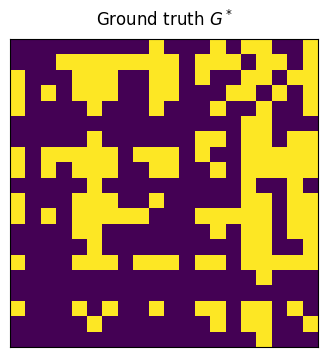

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 3/10
Key:  [4260797006  129535844]
KEY [4260797006  129535844]


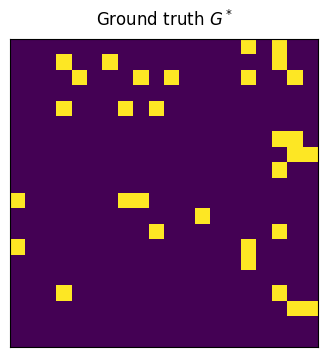

KEY [4260797006  129535844]


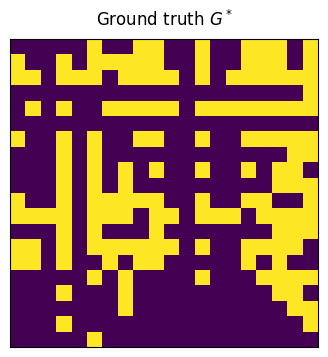

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 4/10
Key:  [ 928977296 1618649917]
KEY [ 928977296 1618649917]


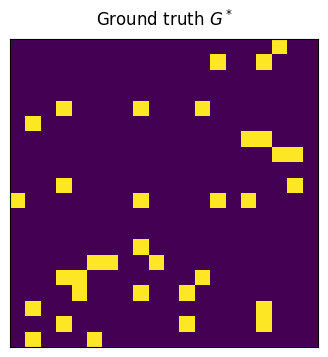

KEY [ 928977296 1618649917]


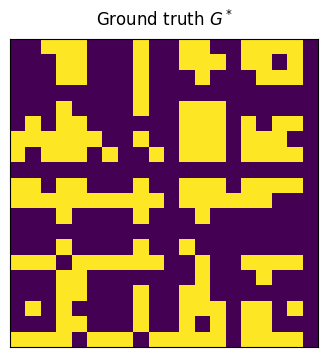

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 5/10
Key:  [2708837749 4129373854]
KEY [2708837749 4129373854]


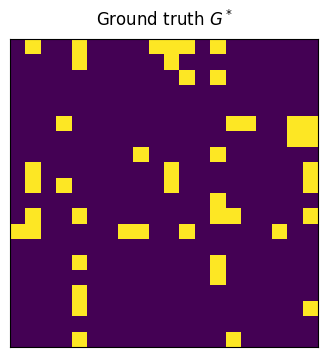

KEY [2708837749 4129373854]


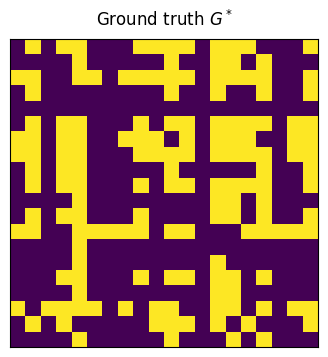

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 6/10
Key:  [ 652965180 3955248629]
KEY [ 652965180 3955248629]


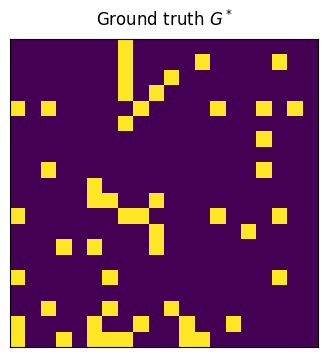

KEY [ 652965180 3955248629]


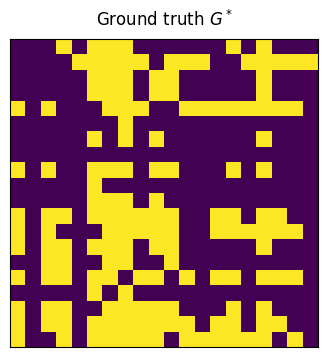

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 7/10
Key:  [1312337421 1285539814]
KEY [1312337421 1285539814]


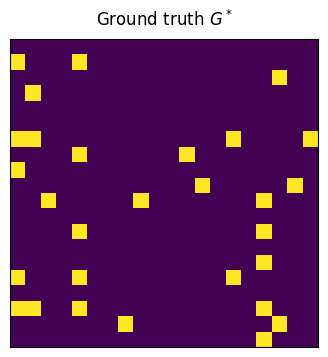

KEY [1312337421 1285539814]


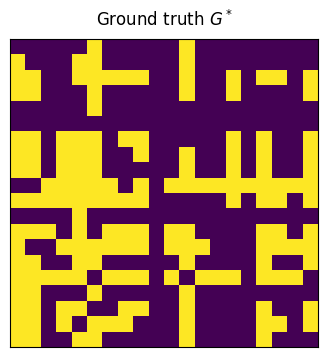

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 8/10
Key:  [2974568872 3669116123]
KEY [2974568872 3669116123]


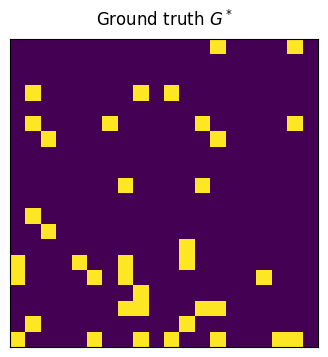

KEY [2974568872 3669116123]


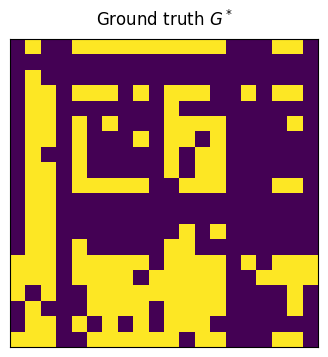

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 9/10
Key:  [1997906629 3379841639]
KEY [1997906629 3379841639]


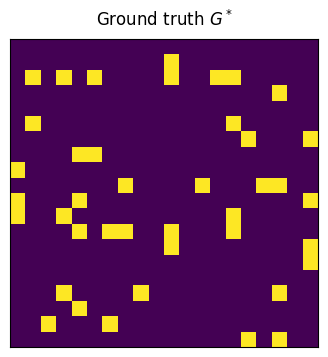

KEY [1997906629 3379841639]


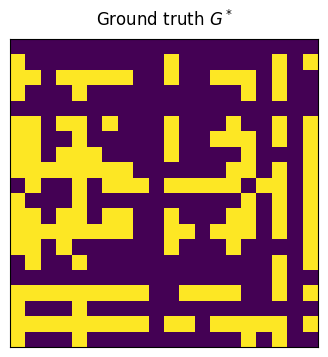

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
Running experiments for network 10/10
Key:  [4278014892 1203387755]
KEY [4278014892 1203387755]


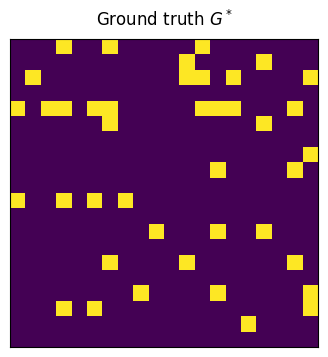

KEY [4278014892 1203387755]


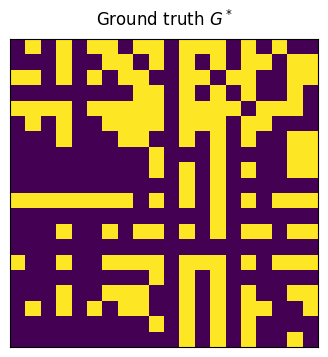

Running configuration: ('er20', 'er20')
Running configuration: ('er20', 'er80')
Running configuration: ('er80', 'er20')
Running configuration: ('er80', 'er80')
    Network Data Type Graph Model        ESHD     AUROC      NegLL
0         1      er20        er20    66.55001  0.803140   2183.086
1         1      er20        er80   140.70001  0.656179  1756.1038
2         1      er80        er20   136.15002  0.584710  2950.6462
3         1      er80        er80   114.45001  0.569829  2109.2446
4         2      er20        er20   60.250004  0.800245  1939.3282
5         2      er20        er80   145.34999  0.707273  1561.7352
6         2      er80        er20   135.60002  0.562648   2645.974
7         2      er80        er80  112.899994  0.652504   2080.046
8         3      er20        er20    65.70001  0.727773   2081.316
9         3      er20        er80   152.90001  0.592185  1634.9591
10        3      er80        er20   137.74998  0.528353   2778.614
11        3      er80        er80   

In [ ]:
results = []

# Split the MAIN_KEY into a separate key for each iteration
network_keys = random.split(MAIN_KEY, N_NETWORKS)

for i, network_key in enumerate(network_keys):
    print(f"Running experiments for network {i+1}/{N_NETWORKS}")

    print("Key: ", network_key)

    # Simulate ER data with edge_p=0.2
    data_er20, graph_model_er20, BGE_LIKELIHOOD_MODEL = simulate_data(
        network_key, N_VARS, "er", N_OBSERVATIONS, edge_p=0.2
    )
    # Simulate ER data with edge_p=0.8
    data_er80, graph_model_er80, _ = simulate_data(
        network_key, N_VARS, "er", N_OBSERVATIONS, edge_p=0.8
    )

    ## Simulate SF data edge_p=0.2
    #data_sf20, graph_model_sf20, _ = simulate_data(
    #    key, N_VARS, "sf", N_OBSERVATIONS, edges_per_node=MEAN_EDGES_PER_NODE_LOWER
    #)

    ## Simulate SF data edge_p=0.8
    #data_sf80, graph_model_sf80, _ = simulate_data(
    #    key, N_VARS, "sf", N_OBSERVATIONS, edges_per_node=MEAN_EDGES_PER_NODE_UPPER
    #)

    # Experiment configurations
    #configs = [
    #    (("er20", "er20"), data_er20, graph_model_er20),
    #    (("er20", "er80"), data_er20, graph_model_er80),
    #    (("er20", "sf20"), data_er20, graph_model_sf20),
    #    (("er20", "sf80"), data_er20, graph_model_sf80),
    #    (("er80", "er20"), data_er80, graph_model_er20),
    #    (("er80", "er80"), data_er80, graph_model_er80),
    #    (("er80", "sf20"), data_er80, graph_model_sf20),
    #    (("er80", "sf80"), data_er80, graph_model_sf80),
    #    (("sf20", "er20"), data_sf20, graph_model_er20),
    #    (("sf20", "er80"), data_sf20, graph_model_er80),
    #    (("sf20", "sf20"), data_sf20, graph_model_sf20),
    #    (("sf20", "sf80"), data_sf20, graph_model_sf80),
    #    (("sf80", "er20"), data_sf80, graph_model_er20),
    #    (("sf80", "er80"), data_sf80, graph_model_er80),
    #    (("sf80", "sf20"), data_sf80, graph_model_sf20),
    #    (("sf80", "sf80"), data_sf80, graph_model_sf80),
    #]

    configs = [
        (("er20", "er20"), data_er20, graph_model_er20),
        (("er20", "er80"), data_er20, graph_model_er80),
        (("er80", "er20"), data_er80, graph_model_er20),
        (("er80", "er80"), data_er80, graph_model_er80),
    ]

    for labels, data, graph_model in configs:
        print("Running configuration:", labels)

        eshd, auroc, negll = run_experiment(
            network_key, data, graph_model, BGE_LIKELIHOOD_MODEL, N_PARTICLES, SVGD_STEPS, OUTPUT_DIR
        )

        results.append({
            "Network": i + 1,
            "Data Type": labels[0],
            "Graph Model": labels[1],
            "ESHD": eshd,
            "AUROC": auroc,
            "NegLL": negll,
        })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv(f"e1_2_results_n{N_OBSERVATIONS}.csv", index=False)

## E2: Variability of included edges for different sample_sizes

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dibs.inference import JointDiBS, MarginalDiBS
from dibs.target import make_linear_gaussian_equivalent_model
from dibs.utils import visualize_ground_truth, visualize
import jax.random as random
from dibs.models.graph import ErdosReniDAGDistribution, ScaleFreeDAGDistribution
from dibs.models import LinearGaussian, BGe, DenseNonlinearGaussian
from dibs.target import make_synthetic_bayes_net

In [10]:
MAIN_KEY = random.PRNGKey(0)
N_VARS = 20  # Adjust as needed
N_PARTICLES = N_VARS  # Adjust as needed
SVGD_STEPS = 3000  # Adjust as needed
OUTPUT_DIR = "output"  # Adjust as needed
DIBS_ITERATIONS = 10
N_OBSERVATIONS = [10, 100, 1000]

In [11]:
def simulate_data(
      key,
      n_vars=20,
      graph_prior_str='sf',
      bge_mean_obs=None,
      bge_alpha_mu=None,
      bge_alpha_lambd=None,
      obs_noise=0.1,
      mean_edge=0.0,
      sig_edge=1.0,
      min_edge=0.5,
      n_observations=100,
      n_ho_observations=100,
      edges_per_node=2
    ):
    assert graph_prior_str in ['er', 'sf']

    print("KEY", key)

    # DiBS uses the edges_per_node instead of p
    # edges_per_node = calculate_edges_per_node(edge_p, n_vars)

    # Graph Model
    if graph_prior_str == 'sf':
        graph_model = ScaleFreeDAGDistribution(
            n_vars=n_vars,
            n_edges_per_node=edges_per_node
        )
    elif graph_prior_str == 'er':
        graph_model = ErdosReniDAGDistribution(
            n_vars=n_vars,
            n_edges_per_node=edges_per_node
        )
    else:
        graph_model = None

    # Generative Model
    generative_model = LinearGaussian(
      n_vars=n_vars,
      obs_noise=obs_noise,
      mean_edge=mean_edge,
      sig_edge=sig_edge,
      min_edge=min_edge,
    )

    # Likelihood Model
    likelihood_model = BGe(
      n_vars=n_vars,
      mean_obs=bge_mean_obs,
      alpha_mu=bge_alpha_mu,
      alpha_lambd=bge_alpha_lambd,
    )

    # Sample synthetic BN and observations
    key, subk = random.split(key)

    data = make_synthetic_bayes_net(
        key=subk,
        n_vars=n_vars,
        graph_model=graph_model,
        generative_model=generative_model,
        n_observations=n_observations,
        n_ho_observations=n_ho_observations,
    )

    visualize_ground_truth(data.g)

    return data, graph_model, likelihood_model


def run_experiment(key, data, graph_model, likelihood_model, n_particles, svgd_steps, output_dir):
    dibs = MarginalDiBS(
        x=data.x, interv_mask=None, graph_model=graph_model, likelihood_model=likelihood_model
    )
    key, subk = random.split(key)
    print("DIBS run key", key)
    gs = dibs.sample(key=subk, n_particles=n_particles, steps=svgd_steps)

    dibs_empirical = dibs.get_empirical(gs)

    eshd, auroc, negll = calculate_scores(
        dibs_empirical, data.g, dibs.eltwise_log_marginal_likelihood_observ, data.x
    )

    return gs, eshd, auroc, negll

# Helper function to calculate scores
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_marginal_likelihood
def calculate_scores(dibs_empirical, ground_truth, eltwise_log_marginal_likelihood_observ, x):

    eshd = expected_shd(dist=dibs_empirical, g=ground_truth)
    auroc = threshold_metrics(dist=dibs_empirical, g=ground_truth)['roc_auc']
    negll = neg_ave_log_marginal_likelihood(
        dist=dibs_empirical, eltwise_log_marginal_likelihood=eltwise_log_marginal_likelihood_observ, x=x
    )
    return eshd, auroc, negll

KEY [0 0]


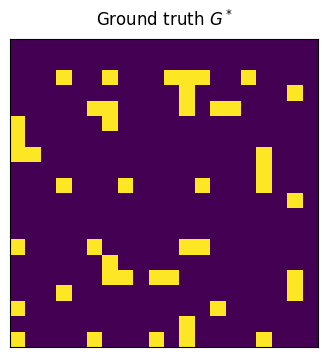

KEY [0 0]


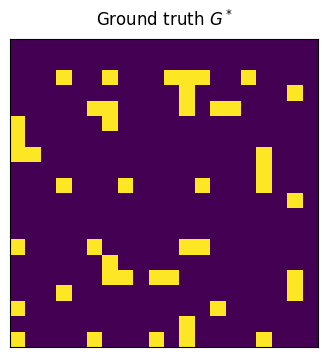

KEY [0 0]


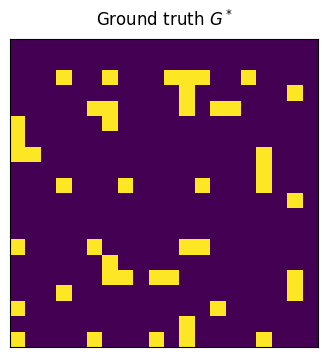

In [13]:
# Simulate ER data with n_observation=10
data_er_n10, GRAPH_MODEL_ER, BGE_LIKELIHOOD_MODEL = simulate_data(
    key=MAIN_KEY, n_vars=N_VARS, graph_prior_str="er", n_observations=10
)

# Simulate ER data with n_observation=100
data_er_n100, _, _ = simulate_data(
    key=MAIN_KEY, n_vars=N_VARS, graph_prior_str="er", n_observations=100
)

# Simulate ER data with n_observation=1000
data_er_n1000, _, _ = simulate_data(
    key=MAIN_KEY, n_vars=N_VARS, graph_prior_str="er", n_observations=1000
)

In [14]:
import pickle

# Assuming 'data_er_n10' is the variable you want to save
with open('data_er_n10.pickle', 'wb') as f:
  pickle.dump(data_er_n10, f)

  # Assuming 'data_er_n10' is the variable you want to save
with open('data_er_n100.pickle', 'wb') as f:
  pickle.dump(data_er_n100, f)

  # Assuming 'data_er_n1000' is the variable you want to save
with open('data_er_n1000.pickle', 'wb') as f:
  pickle.dump(data_er_n1000, f)

In [ ]:
import pandas as pd
import numpy as np
import json

results = []

# Split the MAIN_KEY into a separate key for each iteration
dibs_keys = random.split(MAIN_KEY, DIBS_ITERATIONS)

for i, dibs_key in enumerate(dibs_keys):
    print(f"Running experiments for dibs iteration {i+1}/{DIBS_ITERATIONS}")

    # Experiment configurations
    configs = [
        ("10", data_er_n10),
        ("100", data_er_n100),
        ("1000", data_er_n1000),
    ]

    for n_observations, data in configs:
        print(f"Running configuration with {n_observations} observations")

        gs, eshd, auroc, negll = run_experiment(
            dibs_key, data, GRAPH_MODEL_ER, BGE_LIKELIHOOD_MODEL, N_PARTICLES, SVGD_STEPS, OUTPUT_DIR
        )

        # Compute edge frequency
        edge_count_matrix = sum(gs)  # Summing all adjacency matrices in `gs`

        edge_freq_matrix = edge_count_matrix / N_PARTICLES  # Standardizing by N_PARTICLES

        print(eshd, auroc, negll)

        # Store results with the edge_freq serialized as a JSON string
        results.append({
            "dibs_iteration": i + 1,
            "n_observations": n_observations,
            "edge_freq": json.dumps(edge_freq_matrix.tolist()),  # Convert to list and serialize as JSON
            "ESHD": eshd,
            "AUROC": auroc,
            "NegLL": negll,
        })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv("e2_results.csv", index=False)

Running experiments for dibs iteration 1/10
Running configuration with 10 observations
DIBS run key [3226283459 2011780552]
45.2 0.6242566510172144 202.07242
Running configuration with 100 observations
DIBS run key [3226283459 2011780552]
45.9 0.9059467918622848 925.4793
Running configuration with 1000 observations
DIBS run key [3226283459 2011780552]
49.000008 0.9613145539906103 6289.707
Running experiments for dibs iteration 2/10
Running configuration with 10 observations
DIBS run key [3141584185 3926473090]
45.449993 0.6170892018779343 200.85547
Running configuration with 100 observations
DIBS run key [3141584185 3926473090]
46.100002 0.9124569640062598 923.95105
Running configuration with 1000 observations
DIBS run key [3141584185 3926473090]
51.499992 0.95320813771518 6502.4663
Running experiments for dibs iteration 3/10
Running configuration with 10 observations
DIBS run key [1644682379  552749061]
44.400005 0.652112676056338 200.32977
Running configuration with 100 observations
